# This notebook is to address the selective binding of two small molecules towards two close related protein targets. by quantaosun@gmail.com, in Sydney,2022.

First round docking > First round MD > second round docking > second round MD > MMGBSA(PBSA) > bing free energe estimation > Selectivity quantification.

In [ ]:
!apt-get install vim

# Copy ligand1 and ligand 2 smiles string from Chemdraw to here

In [ ]:
#@title ### **Import Google Drive**
#@markdown Click in the "Run" buttom to make your Google Drive accessible.
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

In [ ]:
#@title Install Conda Rdkit and Open Babel
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local &> /dev/null
! conda install -c rdkit rdkit -y &> /dev/null
!pip install py3Dmol
!time conda install -q -y -c openbabel openbabel
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')


In [5]:
#@title Visualization before docking
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import sys
from collections import defaultdict
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
import pandas as pd

%pylab inline
IPythonConsole.ipython_3d = True

import py3Dmol
import matplotlib.pyplot as plt
import subprocess

Populating the interactive namespace from numpy and matplotlib


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

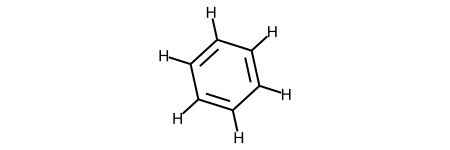

In [85]:
#@title Visualizatino of ligand 1
smiles = "c1ccccc1" #@param {type:"string"}
mol = Chem.MolFromSmiles(smiles) 
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

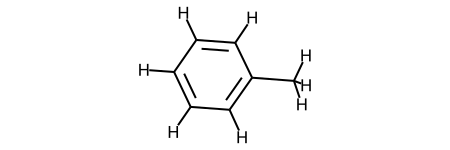

In [86]:
#@title Visualizatino of ligand 2
smiles = "CC1=CC=CC=C1" #@param {type:"string"}
mol = Chem.MolFromSmiles(smiles) 
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.MMFFOptimizeMolecule(mol)
mol

In [87]:
#@title  1）Convert SMILE strings to SDF format
Ligand_1 = "c1ccccc1" #@param {type:"string"}
Ligand_2 = "CC1=CC=CC=C1 " #@param {type:"string"}
!echo "{Ligand_1}" > ligand1.smi
!echo "{Ligand_2}" > ligand2.smi


In [ ]:
!obabel ligand1.smi -osdf -O ligand1.sdf --gen3d
!obabel ligand2.smi -osdf -O ligand2.sdf --gen3d

In [ ]:
#@title Download and install software

!wget --no-check-certificate https://sourceforge.net/projects/smina/files/smina.static/download -O smina.static
!chmod u+x smina.static
#**10.Trust but check （验证一下软件状态正常，正常情况下应当打印出使用说明）**
!./smina.static -h
#**11. 下载一个软件pymol**
!yes | /home/aistudio/external-libraries/bin/conda install -c conda-forge pymol-open-source 

# Provide two targets the selectivity should be addressed

In [ ]:
#@title 👋 Download two protein targets about the Selectivity.
PDB_ID_1 = "3htb" #@param {type:"string"}
PDB_ID_2 = "3ht8" #@param {type:"string"}
pdb_1 = PDB_ID_1 + ".pdb"
pdb_2 = PDB_ID_2 + ".pdb"
! wget https://files.rcsb.org/download/$pdb_1
! wget https://files.rcsb.org/download/$pdb_2


# Visit RCSB to find the Three-letter ligand code, substitute 567 with it
# Use the FOUR-letter pdb code to substitute 1234 below.

# Prepare Protein target 1

In [90]:
#@title Pymol Script_dock_without_water, replace 1234 and 567!
com_file = open('protein_1.pml','w')
com_file.write('''
load XXXX.pdb
remove resn HOH
h_add elem O or elem N
select 1234-567, resn 567 #Create a selection called 1OYT-FSN from the ligand
select 1234-receptor, 4YLJ and not 4YLJ-567 #Select all that is not the ligand
save 1234-567.pdb, 4YLJ-567
save 1234-receptor.pdb, 1234-receptor    
''')
com_file.close()

# Prepare Protein target 2

In [15]:
#@title Pymol Script_dock_without_water, replace 1234 and 567 !
com_file = open('protein_1.pml','w')
com_file.write('''
load XXXX.pdb
remove resn HOH
h_add elem O or elem N
select 1234'-567, resn 567 #Create a selection called 1OYT-FSN from the ligand
select 1234'-receptor, 1234' and not 1234'-567 #Select all that is not the ligand
save 1234'-567.pdb, 1234-567
save 1234'-receptor.pdb, 1234-receptor    
''')
com_file.close()

In [ ]:
#@title Split Targets  before docking

%cd /content
! /home/aistudio/external-libraries/bin/pymol -c protein_1.pml
! /home/aistudio/external-libraries/bin/pymol -c protein_2.pml

In [28]:
#@title Define ligand1 path and number
# File locations
sdfFilePath = 'ligand1.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand1_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [29]:
#@title Check names of SDF
for i, mol in enumerate(inputMols):
    if mol is None:
        print('Warning: Failed to read molecule %s in %s' % (i, sdfFilePath))
    if not mol.GetProp('_Name'):

        print('Warning: No name for molecule %s in %s' % (i, sdfFilePath))

In [30]:
#@title SDF conformation generation
import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


**Warning ☹ Always have a look to make sure there are no multimers, otherwise the docking will be problematic later.**

In [91]:
#@title 👋 Input names needed for ligand1 and Dyrk1A.
ProteinForDocking = "1234-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "1234-4E1.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand1_Docked_1234.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligand1_FlexibleDocked_1234.sdf.gz" #@param {type:"string"}



# Docking of protein 1 and ligand 1

In [32]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{Docked_out_FilePath}'

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|

In [33]:
#@title Define ligand2 path and number
# File locations
sdfFilePath = 'ligand2.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand2_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [34]:
#@title SDF conformation generation for ligand2

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


In [35]:
#@title 👋 Input names needed for ligand2 and Dyrk1A.
ProteinForDocking = "4YLJ-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "4YLJ-4E1.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand2_Docked_4YLJ.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligands_FlexibleDocked_6I5I.sdf.gz" #@param {type:"string"}

# Docking of protein 1 and ligand 2

In [36]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{Docked_out_FilePath}'

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|

# Docking of protein 2 and ligand 1

In [37]:
#@title Define ligand1 path and number
# File locations
sdfFilePath = 'ligand1.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand1_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [38]:
#@title SDF conformation generation for ligand1

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


In [39]:
#@title 👋 Input names needed for ligand2 and Dyrk1A.
ProteinForDocking = "6I5I-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "6I5I-H3E.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand1_Docked_6I5I.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligands_FlexibleDocked_6I5I.sdf.gz" #@param {type:"string"}

In [40]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{Docked_out_FilePath}'

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|

# Docking of protein 2 and ligand 2

In [41]:
#@title Define ligand2 path and number
# File locations
sdfFilePath = 'ligand2.sdf' #@param {type:"string"}
ConfoutputFilePath = 'ligand2_conformation.sdf' #@param {type:"string"}

inputMols = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
# Assign atomic chirality based on the structures:
len(inputMols) # Check how many strucures

1

In [42]:
#@title SDF conformation generation for ligand2

import multiprocessing

# Download this from http://pypi.python.org/pypi/futures
from concurrent import futures

# conda install progressbar
import progressbar

#Find number cores available, leave two or system might be unresponsive
numcores = multiprocessing.cpu_count()
max_workers = numcores #-1

#Knowledge based torsion generator http://pubs.acs.org/doi/abs/10.1021/acs.jcim.5b00654
# This function is called in the subprocess.
# The parameters (molecule and number of conformers) are passed via a Python

ps = AllChem.ETKDG()
ps.pruneRmsThresh=0.5
ps.numThreads=0
#Edit for number of confs desired eg n = 5
n=5
def generateconformations(m, n, name):
    m = Chem.AddHs(m)
    ids=AllChem.EmbedMultipleConfs(m, n, ps)
    for id in ids:
        AllChem.UFFOptimizeMolecule(m, confId=id)
    # EmbedMultipleConfs returns a Boost-wrapped type which
    # cannot be pickled. Convert it to a Python list, which can.
    return m, list(ids), name

smi_input_file, sdf_output_file = sys.argv[1:3]


writer = Chem.SDWriter(ConfoutputFilePath)
# suppl = [x for x in Chem.SDMolSupplier(sdfFilePath,removeHs=False)]
#suppl = Chem.SmilesMolSupplier(smi_input_file, titleLine=False)

# for mol in suppl:
#     print(mol.GetPropsAsDict(includePrivate=True).get('_Name'))

with futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    # Submit a set of asynchronous jobs
    jobs = []
    for mol in inputMols:
        if mol:
            name = mol.GetProp('_Name')
            job = executor.submit(generateconformations, mol, n, name)
            jobs.append(job)

    widgets = ["Generating conformations; ", progressbar.Percentage(), " ",
               progressbar.ETA(), " ", progressbar.Bar()]
    pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(jobs))
    for job in pbar(futures.as_completed(jobs)):
        mol, ids, name = job.result()
        mol.SetProp('_Name', name)
        for id in ids:
            writer.write(mol, confId=id)
writer.close()

Generating conformations; 100% Time:  0:00:00 |###############################|


In [43]:
#@title 👋 Input names needed for ligand2 and Dyrk1A.
ProteinForDocking = "6I5I-receptor.pdb" #@param {type:"string"}
LigandFromProtein = "6I5I-H3E.pdb" #@param {type:"string"}
Docked_out_FilePath = "ligand2_Docked_6I5I.sdf" #@param {type:"string"}
FlexibleDockedFilePath = "ligand2_FlexibleDocked_6I5I.sdf.gz" #@param {type:"string"}

In [44]:
!'./smina.static' --cpu 2 --seed 0 --autobox_ligand '{LigandFromProtein}' -r '{ProteinForDocking}' -l '{ConfoutputFilePath}' -o '{Docked_out_FilePath}'

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 0

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|

In [ ]:
#@title Primary school math time, S1,target1/target2 = Docking score 1,targe1-Docking score1,target2
 

# Post-dock processing, convert file format for visualization puroose，modify 4-letter code accordingly

In [77]:
%cd /content/Docked_first

/content/Docked_first


In [75]:
!obabel -isdf ligand1_Docked_1234.sdf -opdb -O 1_1.pdb -m
!mkdir 1_1
!mv *1_1* 1/

27 molecules converted
27 files output. The first is 1_11.pdb


In [78]:
!obabel -isdf ligand2_Docked_1234.sdf -opdb -O 1_2.pdb -m
!mkdir 1_2
!mv *1_2* 1_2/

36 molecules converted
36 files output. The first is 1_21.pdb
mkdir: cannot create directory ‘1_2’: File exists
mv: cannot move '1_2' to a subdirectory of itself, '1_2/1_2'


In [80]:
!obabel -isdf ligand1_Docked_1234'.sdf -opdb -O 2_1.pdb -m
!mkdir 2_1
!mv *2_1* 2_1/

27 molecules converted
27 files output. The first is 2_11.pdb
mv: cannot move '2_1' to a subdirectory of itself, '2_1/2_1'


In [82]:
!obabel -isdf ligand2_Docked_1234'.sdf -opdb -O 2_2.pdb -m
!mkdir 2_2
!mv *2_2* 2_2/

36 molecules converted
36 files output. The first is 2_21.pdb
mv: cannot move '2_2' to a subdirectory of itself, '2_2/2_2'


# Now you can download the top1 docked pdb from the 4 independent dockings, as representative binding modes. 